In [39]:
import requests # Загрузка новостей с сайта.
from bs4 import BeautifulSoup # Превращалка html в текст.
import re

import pandas as pd
pd.set_option('display.max_rows', 500)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import preprocessing

import numpy as np
import nltk
nltk.download(['averaged_perceptron_tagger_ru', 'stopwords'])
stopwords = nltk.corpus.stopwords.words('russian')
#можно расширить список стоп-слов
stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

from tqdm import tqdm
import pymorphy2
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['figure.figsize'] = (12, 8)

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\Anastasia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anastasia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.DataFrame(columns=['articles','category','url'], index = range(2000))


In [4]:
for x in range(1063000, 1061000, -1):
    h3s = BeautifulSoup(requests.get(f"https://iz.ru/{x}").text, "html.parser").find_all("div", {"id": "block-purple-content"})
    txts = ' '.join(re.findall("<p>(.*?)</p>", str(h3s)))
    txts = re.sub("<[/ai](.*?)>", "", txts)
    try:
        rub = ''.join([l.find_all("a")[0]['href'] for l in h3s])
        rub = rub.replace("/rubric/", "")
    except:
        rub = 'NaN'
    df.loc[x-1061001].articles = txts
    df.loc[x-1061001].category = rub
    df.loc[x-1061001].url = "https://iz.ru/" + str(x)
df

,articles,category,url
0,,obshchestvo,https://iz.ru/1061001
1,,obshchestvo,https://iz.ru/1061002
2,Генеральный директор МИЦ «Известия» Владимир Т...,/press-release,https://iz.ru/1061003
3,,obshchestvo,https://iz.ru/1061004
4,<u>Плата за посещение заповедников и нацпарков...,https://iz.ru/1061005/maksim-prikhoda/ne-ponim...,https://iz.ru/1061005
...,...,...,...
1995,Средний сын президента Белоруссии Дмитрий Лука...,mir,https://iz.ru/1062996
1996,Депутат городского совета Новосибирска Наталья...,obshchestvo,https://iz.ru/1062997
1997,В России в условиях эпидемии коронавируса удал...,armiia,https://iz.ru/1062998
1998,Новый сезон НХЛ может начаться в январе. Заявл...,sport,https://iz.ru/1062999


In [19]:
df2 = df

In [20]:
df2 = df2.drop(df2[df2['articles'] == ""].index)
df2 = df2.drop(df2[df2['articles'] == " "].index)
df2 = df2.drop(df2[df2['category'].str.contains('https', regex=False)].index)
df2 = df2.reset_index(drop=True)

In [21]:
print(df2.groupby('category')['url'].nunique())

category
/press-release      9
armiia             39
auto               48
ekonomika          75
internet           16
kultura            38
mir               431
nauka              43
obshchestvo       377
politika           33
proisshestviia     91
sport              72
strana            228
turizm             21
Name: url, dtype: int64


In [22]:
df2 = df2.drop(df2[df2['category'] == "/press-release"].index)
df2 = df2.drop(df2[df2['category'] == "armiia"].index)
df2 = df2.drop(df2[df2['category'] == "auto"].index)
df2 = df2.drop(df2[df2['category'] == "internet"].index)
df2 = df2.drop(df2[df2['category'] == "kultura"].index)
df2 = df2.drop(df2[df2['category'] == "nauka"].index)
df2 = df2.drop(df2[df2['category'] == "novosti-kompanii"].index)
df2 = df2.drop(df2[df2['category'] == "obshchestvo"].index)
df2 = df2.drop(df2[df2['category'] == "politika"].index)
df2 = df2.drop(df2[df2['category'] == "proisshestviia"].index)
df2 = df2.drop(df2[df2['category'] == "stil"].index)
df2 = df2.drop(df2[df2['category'] == "strana"].index)
df2 = df2.drop(df2[df2['category'] == "turizm"].index)
df2 = df2.reset_index(drop=True)
print(df2.groupby('category')['articles'].nunique())

category
ekonomika     75
mir          430
sport         72
Name: articles, dtype: int64


In [23]:
df2

,articles,category,url
0,Несколько лет назад президент США Дональд Трам...,mir,https://iz.ru/1061007
1,Американские антирасисты устроили погром на ул...,mir,https://iz.ru/1061008
2,На Украине произошел взрыв на одном из газопро...,ekonomika,https://iz.ru/1061028
3,Администрация президента США Дональда Трампа 1...,mir,https://iz.ru/1061032
4,Арбитраж Всемирной торговой организации (ВТО) ...,mir,https://iz.ru/1061039
...,...,...,...
573,"Большую часть кредита в $500 млн, который Бело...",ekonomika,https://iz.ru/1062992
574,Несколько участников запланированной в Минске ...,mir,https://iz.ru/1062995
575,Средний сын президента Белоруссии Дмитрий Лука...,mir,https://iz.ru/1062996
576,Новый сезон НХЛ может начаться в январе. Заявл...,sport,https://iz.ru/1062999


In [24]:
df2 = df2.drop(['url'], axis=1)

In [25]:
morph = pymorphy2.MorphAnalyzer()

In [27]:
imp_POS = ['ADJF', 'ADJS', 'NOUN', 'VERB', 'PRTF', 'PRTS', 'GRND']
def getMostFrequentWordsFiltered(text):
    
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in imp_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
    text = ' '.join(words)
    
    counter=CountVectorizer(ngram_range=(1,2), stop_words=stopwords, token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')
    res=counter.fit_transform([text])
    frq = sorted([(i, int(res[0][0,i])) for i in range(res[0].shape[1])], key = lambda x: x[1], reverse = True)[:5]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] for i, f in frq], vocab

In [28]:
freqwords = []
vocabs = []
for i in tqdm(range(df2.shape[0])):
    fw, v = getMostFrequentWordsFiltered(df2.articles.iloc[i])
    freqwords.append(fw)
    vocabs.append(v)
    
df2['Vocabular'] = vocabs
df2['Freq Words'] = freqwords
df2.head(10)

100%|██████████| 578/578 [01:15<00:00,  7.68it/s]


,articles,category,Vocabular,Freq Words
0,Несколько лет назад президент США Дональд Трам...,mir,"{'год': 4, 'президент': 2, 'сша': 2, 'дональд'...","[трамп, год, заявить, мэттис, войско]"
1,Американские антирасисты устроили погром на ул...,mir,"{'американский': 1, 'антирасист': 2, 'устроить...","[антирасист, муньос, полицейский, автомобиль, ..."
2,На Украине произошел взрыв на одном из газопро...,ekonomika,"{'украина': 13, 'произойти': 3, 'взрыв': 3, 'г...","[год, украина, украинский, газопровод, который]"
3,Администрация президента США Дональда Трампа 1...,mir,"{'администрация': 1, 'президент': 3, 'сша': 5,...","[американский, компания, сегмент, сентябрь, сша]"
4,Арбитраж Всемирной торговой организации (ВТО) ...,mir,"{'арбитраж': 1, 'всемирный': 1, 'торговый': 2,...","[год, пошлина, вто, сша, товар]"
5,В ходе состоявшегося во вторник телефонного ра...,mir,"{'ход': 3, 'состояться': 2, 'вторник': 1, 'тел...","[навальный, российский, сентябрь, россия, блогер]"
6,Главы МИД России и Италии Сергей Лавров и Луид...,mir,"{'глава': 2, 'мид': 2, 'россия': 3, 'италия': ...","[белоруссия, лукашенко, проведение, инициатива..."
7,Совместные военные учения России и Белоруссии ...,mir,"{'совместный': 1, 'военный': 3, 'учение': 6, '...","[учение, военный, гвардейский, литва, подразде..."
8,Премьер-министр России Михаил Мишустин провел ...,mir,"{'премьер-министр': 1, 'россия': 1, 'михаил': ...","[взаимодействие, государство, мишустин, союзны..."
9,Глава департамента по работе с соотечественник...,mir,"{'глава': 1, 'департамент': 3, 'работа': 1, 'с...","[год, посол, россия, рф, мид]"


In [29]:
#Приведем все слова текста к начальным формам
def normalizePymorphy2(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        words.append(pv[0].normal_form)
    return words

In [30]:
#Посчитаем наиболее важные по TF*IDF слова и пары слов
tfCounter = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)
tfres = tfCounter.fit_transform([' '.join(normalizePymorphy2(n)) for n in df2.articles] )

In [31]:
#Подсчет самых важных 5 слов в документе
freqwords = []
for i in tqdm(range(df2.shape[0])):

    tfs = [(k,tfres[i][0, tfCounter.vocabulary_.get(k)]) for k in df2.Vocabular.iloc[i] 
         if k in tfCounter.vocabulary_.keys()]
    fw = [w for w, f in sorted(tfs, key = lambda x: x[1], reverse = True)[:5]]
    freqwords.append(fw)
    
df2['Freq Words TFIDF'] = freqwords
df2.head(10)

100%|██████████| 578/578 [00:17<00:00, 32.22it/s]


,articles,category,Vocabular,Freq Words,Freq Words TFIDF
0,Несколько лет назад президент США Дональд Трам...,mir,"{'год': 4, 'президент': 2, 'сша': 2, 'дональд'...","[трамп, год, заявить, мэттис, войско]","[мэттис, трамп, войско, вывод, сирия]"
1,Американские антирасисты устроили погром на ул...,mir,"{'американский': 1, 'антирасист': 2, 'устроить...","[антирасист, муньос, полицейский, автомобиль, ...","[муньос, антирасист, полицейский, ланкастер, ш..."
2,На Украине произошел взрыв на одном из газопро...,ekonomika,"{'украина': 13, 'произойти': 3, 'взрыв': 3, 'г...","[год, украина, украинский, газопровод, который]","[украинский, украина, газопровод, труба, транзит]"
3,Администрация президента США Дональда Трампа 1...,mir,"{'администрация': 1, 'президент': 3, 'сша': 5,...","[американский, компания, сегмент, сентябрь, сша]","[сегмент, американский сегмент, приложение, ам..."
4,Арбитраж Всемирной торговой организации (ВТО) ...,mir,"{'арбитраж': 1, 'всемирный': 1, 'торговый': 2,...","[год, пошлина, вто, сша, товар]","[пошлина, вто, товар, ряд, третейский]"
5,В ходе состоявшегося во вторник телефонного ра...,mir,"{'ход': 3, 'состояться': 2, 'вторник': 1, 'тел...","[навальный, российский, сентябрь, россия, блогер]","[навальный, блогер, вещество, требоваться пере..."
6,Главы МИД России и Италии Сергей Лавров и Луид...,mir,"{'глава': 2, 'мид': 2, 'россия': 3, 'италия': ...","[белоруссия, лукашенко, проведение, инициатива...","[инициатива проведение, конституционный реформ..."
7,Совместные военные учения России и Белоруссии ...,mir,"{'совместный': 1, 'военный': 3, 'учение': 6, '...","[учение, военный, гвардейский, литва, подразде...","[учение, гвардейский, подразделение, кароблис,..."
8,Премьер-министр России Михаил Мишустин провел ...,mir,"{'премьер-министр': 1, 'россия': 1, 'михаил': ...","[взаимодействие, государство, мишустин, союзны...","[союзный, союзный государство, мишустин, взаим..."
9,Глава департамента по работе с соотечественник...,mir,"{'глава': 1, 'департамент': 3, 'работа': 1, 'с...","[год, посол, россия, рф, мид]","[посол, мальгин, человек мид, узбекистан, депа..."


In [32]:
df2 = df2.drop(['Vocabular'], axis=1)
df2 = df2.drop(['Freq Words'], axis=1)

le = preprocessing.LabelEncoder()

df2['category'] = le.fit_transform(df2['category'])

df2

,articles,category,Freq Words TFIDF
0,Несколько лет назад президент США Дональд Трам...,1,"[мэттис, трамп, войско, вывод, сирия]"
1,Американские антирасисты устроили погром на ул...,1,"[муньос, антирасист, полицейский, ланкастер, ш..."
2,На Украине произошел взрыв на одном из газопро...,0,"[украинский, украина, газопровод, труба, транзит]"
3,Администрация президента США Дональда Трампа 1...,1,"[сегмент, американский сегмент, приложение, ам..."
4,Арбитраж Всемирной торговой организации (ВТО) ...,1,"[пошлина, вто, товар, ряд, третейский]"
...,...,...,...
573,"Большую часть кредита в $500 млн, который Бело...",0,"[кредит, млн, кредит млн, ефср, евразийский фонд]"
574,Несколько участников запланированной в Минске ...,1,"[минск, станция, акция, минский, задержать]"
575,Средний сын президента Белоруссии Дмитрий Лука...,1,"[учиться, дочь, школа, лукашенко, сын]"
576,Новый сезон НХЛ может начаться в январе. Заявл...,2,"[нхл, сезон, чемпионат, гэри, беттмэн]"


In [43]:
eblow_crit = []

for k in tqdm(range(1, 16)):
    eblow_crit.append(KMeans(n_clusters=k, random_state=None).fit(tfres).inertia_)

100%|██████████| 15/15 [07:21<00:00, 29.41s/it]


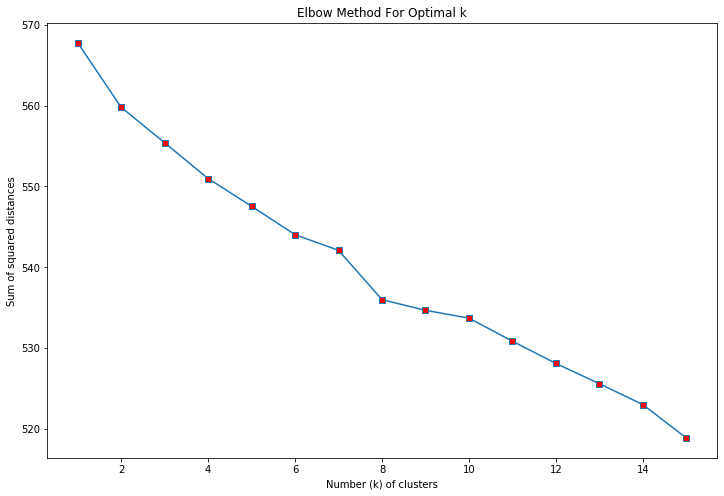

In [44]:
plt.plot(range(1, 16), eblow_crit, marker = 's', mfc = 'red')
plt.xlabel('Number (k) of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [45]:
km = KMeans(n_clusters=3, random_state=None).fit(tfres)
classes = km.labels_

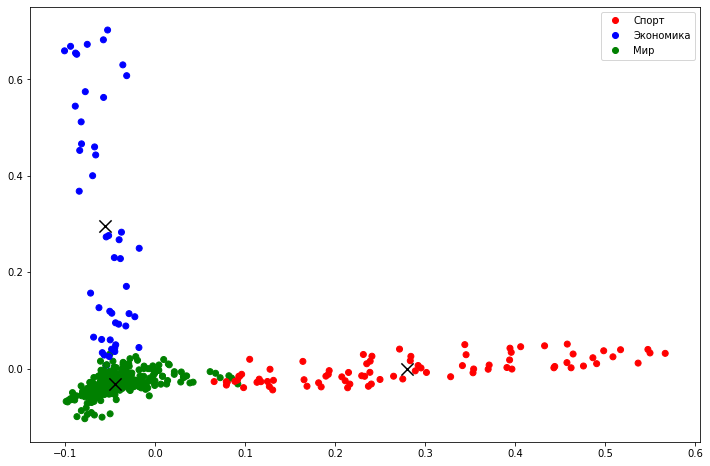

In [47]:
# Уменьшим размерность до 2D
pca = PCA(n_components=2, random_state=1)
reduced_features = pca.fit_transform(tfres.toarray())

# Уменьшим центры кластеров до 2D
reduced_cluster_centers = pca.transform(kmeans1.cluster_centers_)

classes = ['Спорт', 'Экономика', 'Мир']
colours = ListedColormap(['r','b','g'])
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans1.predict(tfres), cmap=colours)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='black')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)